# Housing Prices Data Wrangle

The first part of this analysis is a copy of Pedro Marcelinos work on multivariable anaylsis. 

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [180]:
# Import training data
df_train = pd.read_csv('./train.csv')

In [181]:
# Check columns 
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Visualize the data to get to know it

**Which variables do I expect to be important?**

GrLivArea, SaleCondition, YearBuilt -- most likely. Let's find out. 


In [182]:
# Describe SalePrice
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

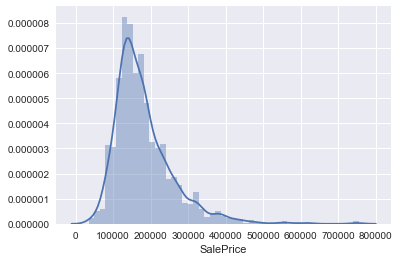

In [183]:
# Histogram 
sns.distplot(df_train['SalePrice'])

**Positive skew, peakedness**

In [184]:
# Skewness and kurtosis values
print("Skewness: {}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {}".format(df_train['SalePrice'].kurtosis()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


**Compare SalePrice to other variables**


In [185]:
# Scatterplots of variables v. SalePrice 

# Note that SaleCondition is categorical, so this representation wouldn't be ideal
def scatter(var):
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    data.plot.scatter(x=var,y='SalePrice')

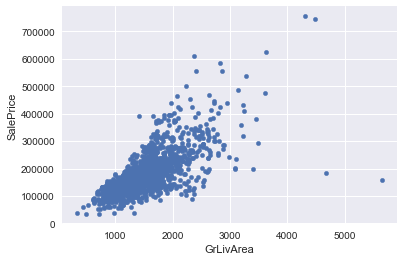

In [186]:
scatter('GrLivArea')

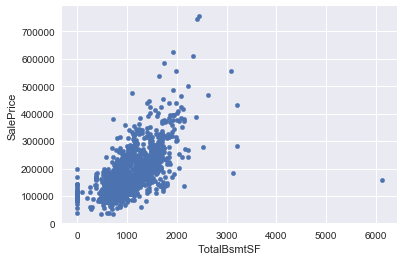

In [187]:
scatter('TotalBsmtSF')

In [188]:
# Box plots for categorical data

def box(var):
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    plt.subplots(figsize=(16,8))
    fig = sns.boxplot(x=var,y='SalePrice', data=data)

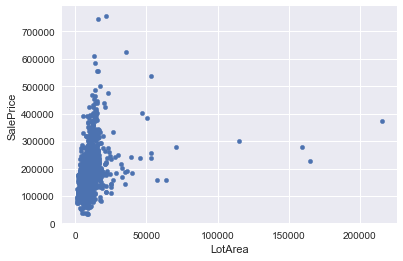

In [189]:
scatter('LotArea')

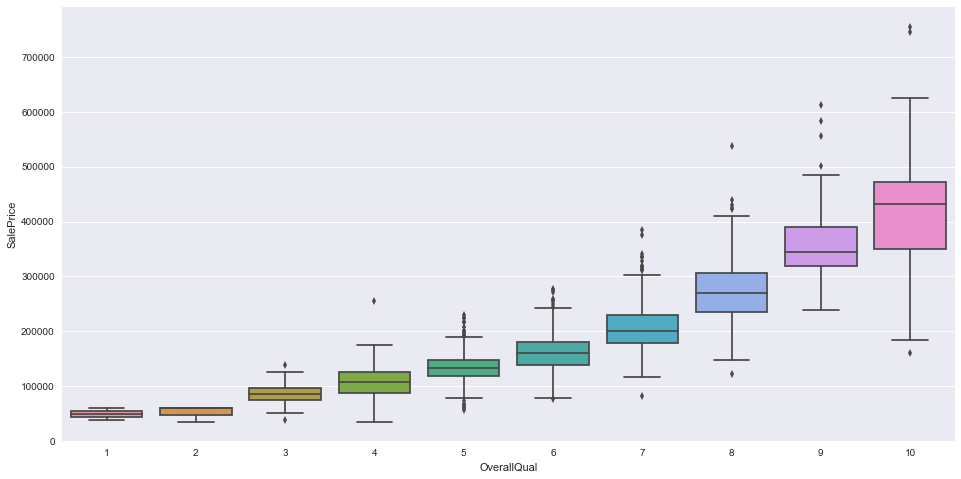

In [190]:
box('OverallQual')

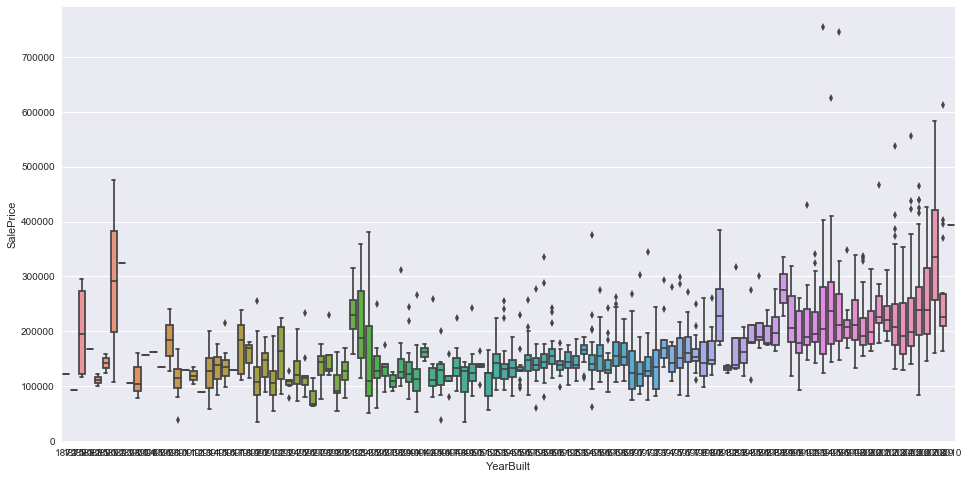

In [191]:
box('YearBuilt')

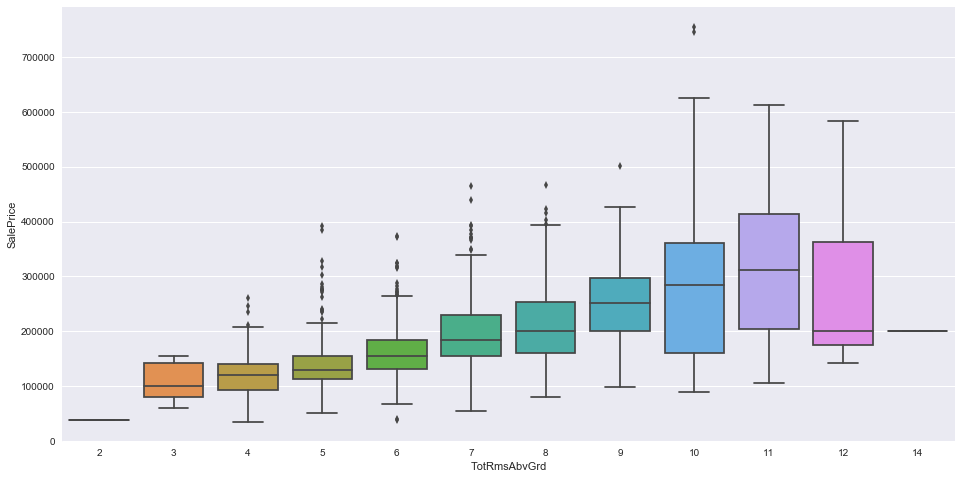

In [192]:
box('TotRmsAbvGrd')

## Correlation matrix as heatmap (brilliant!)

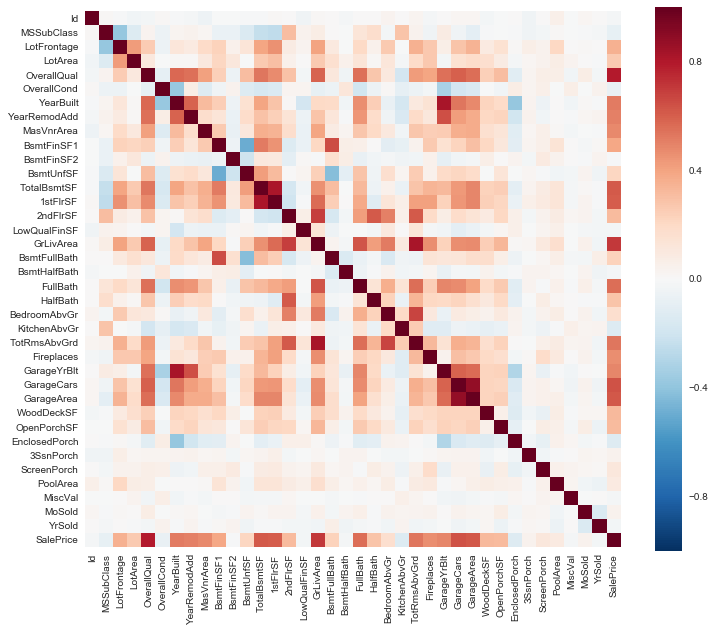

In [193]:
# Corrmat
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, square=True)

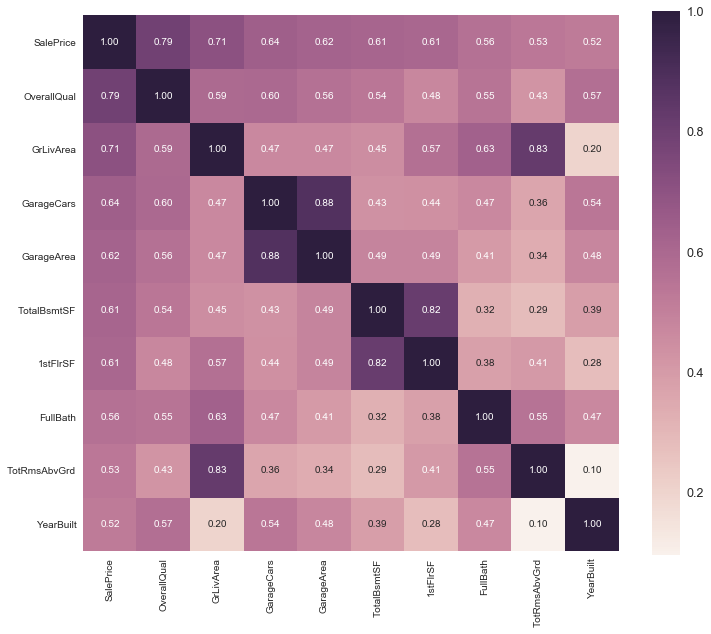

In [194]:
# Pick the top k correlated variables with SalePrice for further analysis 
k = 10 # number of variables in matrix
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # Find k largest correletions with SalePrice vs. SalePrice by index
cm = np.corrcoef(df_train[cols].values.T)
fig, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, square=True, annot=True, annot_kws={'size':10}, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)

**What does that tell me?**

TotRmsAbvGrd and GrLivArea can probably be combined. GarageArea and GaraageCars can be combined. 1stFlrSF and TotalBsmtSF can be combined. 

Let's pick OverallQual, GrLivArea, GarageCars, TotalBsmtSF, FullBath, YearBuilt. 

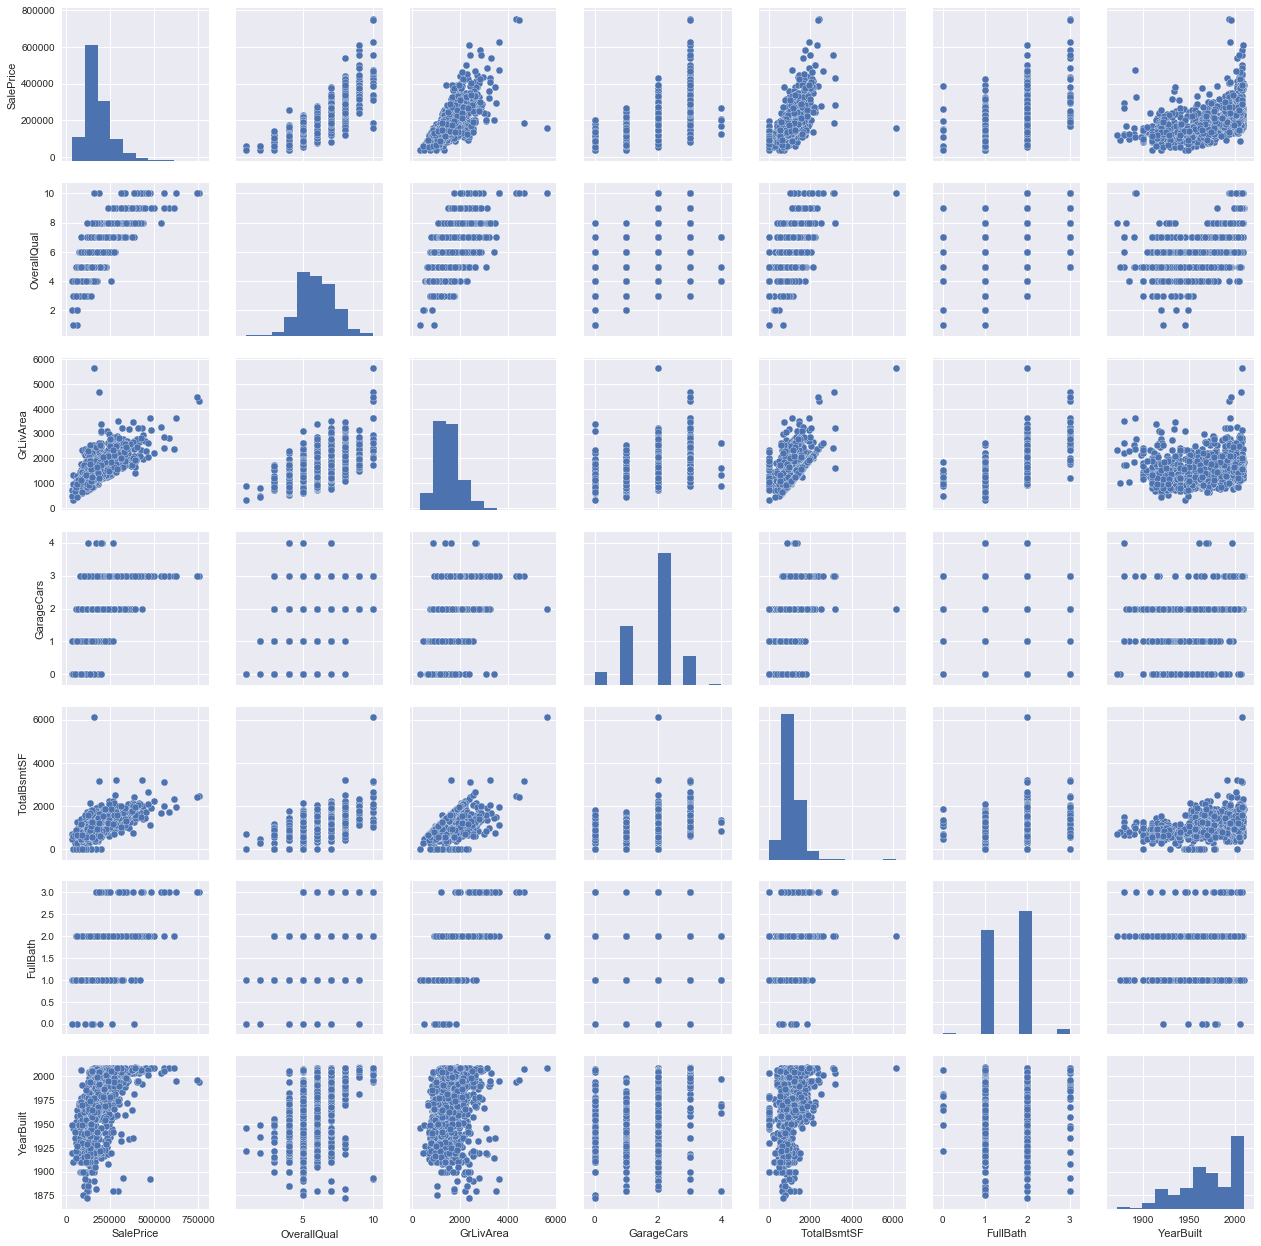

In [195]:
# Mini scatters
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols]) # Neat! 

## Remove missing data

In [196]:
# Missing data

total_missing = df_train.isnull().sum().sort_values(ascending=False)
percent_missing = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


**How should we handle missing data?**
If more than 15% is missing, throw out the entire variable. Otherwise, see if the variable is necessary given the top correlated variables from above. If they aren't relavent, toss them. For things like Electrical, which is only missing 1 value, delete that one value. 

In [197]:
# Drop missing values that aren't relevant
try:
    df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1) 
except: 
    pass

try: 
    df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
except:
    pass

# Check the they were removed
df_train.isnull().sum().max()

0

## Outlier removal

**Start by standardizing the data and look at the lower 10 entries and the upper 10 entries**

Univariate

In [198]:
# Standardizing
standardized_saleprice = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range = standardized_saleprice[standardized_saleprice[:,0].argsort()][:10]
high_range= standardized_saleprice[standardized_saleprice[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


Bivariate

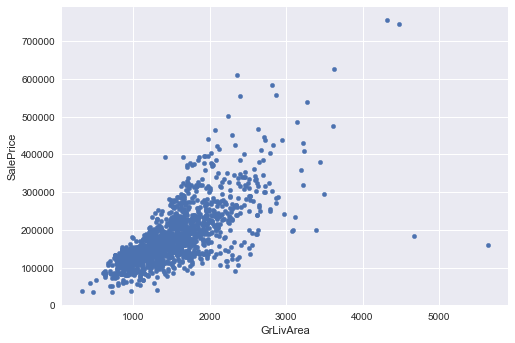

In [199]:
scatter('GrLivArea')

In [200]:
# Find those two outliers
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [201]:
# Delete them
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

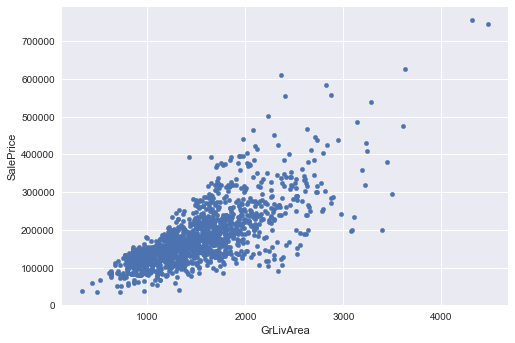

In [202]:
# Better! 
scatter('GrLivArea')

**Don't forget to check your other variables, but don't go crazy removing observations unless they clearly don't belong**

## The Four Horsemen

Check for **normality**, **homoscedasticity**, **linearity**, **absence of correlated errors**. (See Hair(2013) for details)

**Normality**

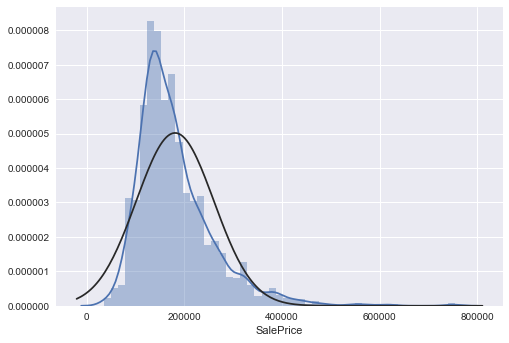

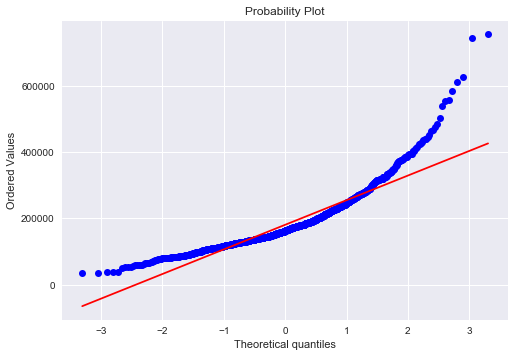

In [203]:
# Histogram and normality plot
var = 'SalePrice'
sns.distplot(df_train[var], fit=norm)
fig = plt.figure()

# Residuals
res = stats.probplot(df_train[var], plot=plt)

Apparently, in case of positive skewness, log transformations usually work well (sweet!). Things like this are great reasons to read statistics books.

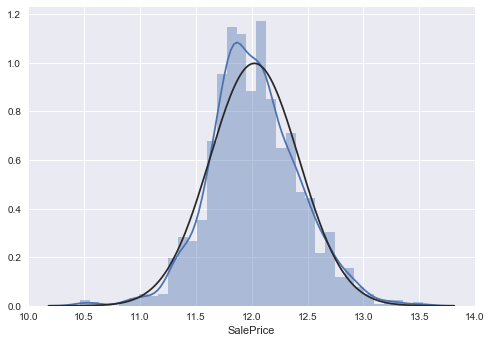

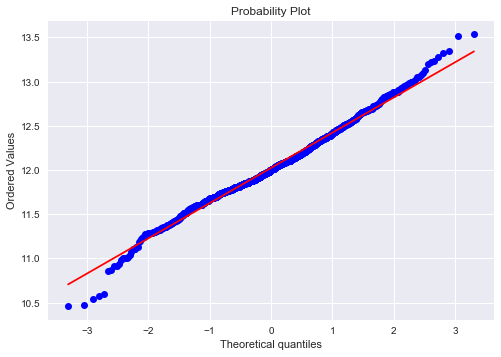

In [204]:
# Let's see! 
saleprice_log = np.log(df_train['SalePrice'])

sns.distplot(saleprice_log, fit=norm)
fig = plt.figure()

# Residuals
res = stats.probplot(saleprice_log, plot=plt)

In [205]:
# Not bad. Let's keep it
df_train['SalePrice'] = np.log(df_train['SalePrice'])

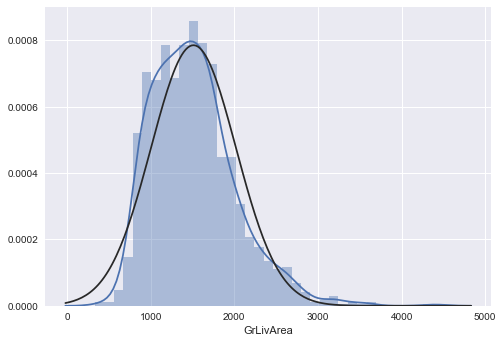

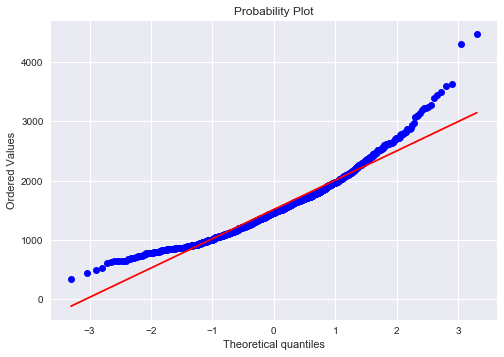

In [206]:
# Next variable
var = 'GrLivArea'
sns.distplot(df_train[var], fit=norm)
fig = plt.figure()

# Residuals
res = stats.probplot(df_train[var], plot=plt)

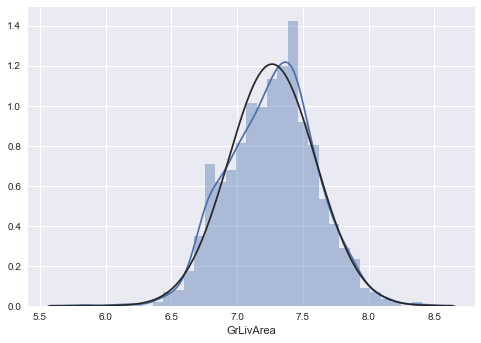

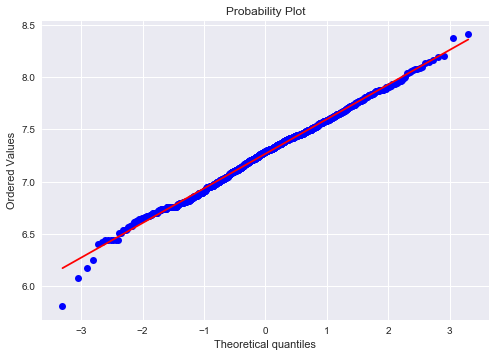

In [207]:
# Same positive skewness. 
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

# Better
var = 'GrLivArea'
sns.distplot(df_train[var], fit=norm)
fig = plt.figure()

# Residuals
res = stats.probplot(df_train[var], plot=plt)

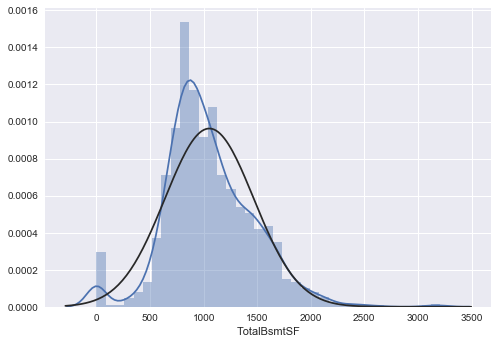

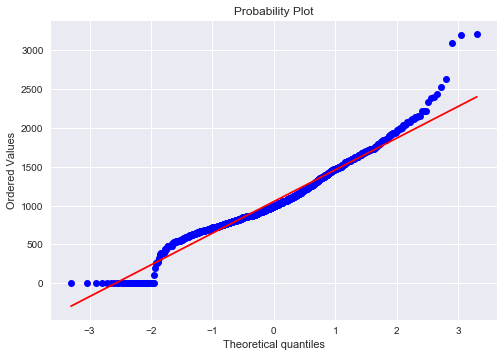

In [208]:
# Last variable

var = 'TotalBsmtSF'
sns.distplot(df_train[var], fit=norm)
fig = plt.figure()

# Residuals
res = stats.probplot(df_train[var], plot=plt)

That one is rough. All of those 0 values prevent a log transformation, so let's transform only the nonzero values. 

In [209]:
# Transform nonzero values
df_train['TotalBsmtSF'][df_train['TotalBsmtSF'] != 0] = np.log(df_train['TotalBsmtSF'])

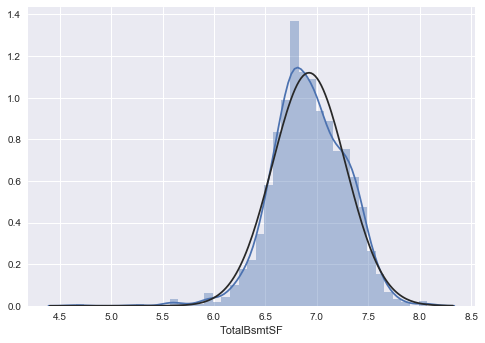

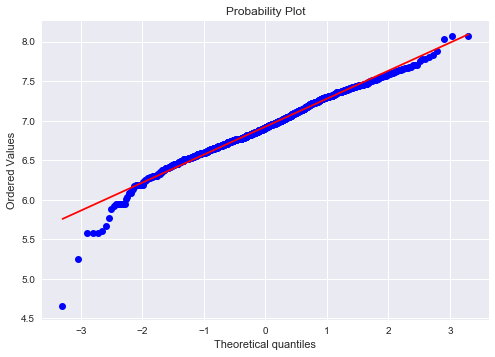

In [210]:
# Plot nonzero values
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

**Homoscedasticity**

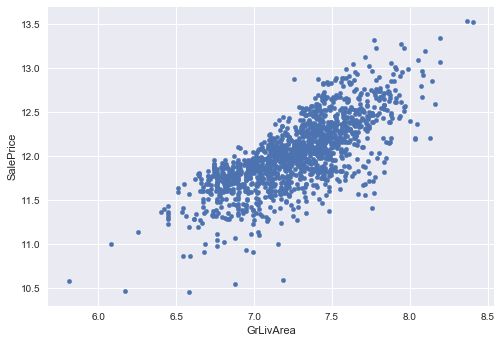

In [211]:
# Fortunately, the normalization gave us homoscedasticity as well. 
scatter('GrLivArea')

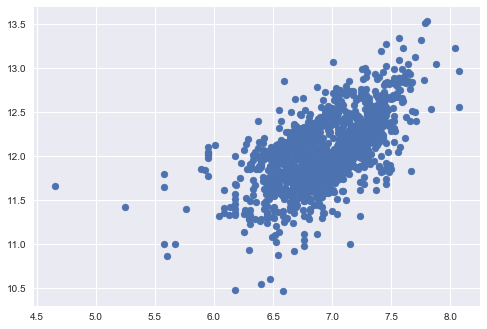

In [212]:
# Same here (for nonzeros)
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

## Create dummies of categorical data

In [213]:
# Make categorical data dummies
df_train = pd.get_dummies(df_train)

## Export the data and get testing! 

In [214]:
df_train.to_csv('wrangled_data.csv')
df_train = pd.read_csv('./wrangled_data.csv')
df_train.columns

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=222)

In [215]:
# Split the data

from sklearn.model_selection import train_test_split

X_all = df_train.drop(['SalePrice'], axis=1)
y_all = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all)

In [216]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Make a classifier
clf = DecisionTreeRegressor()

# Choose parameters to try
parameters = { 'splitter' : ['best', 'random'],
               'max_features' : ['log2', 'sqrt', 'auto'], 
               'criterion' : ['mse'],
               'max_depth' : [2, 3, 5, 10], 
               'min_samples_split' : [2, 3, 5], 
               'min_samples_leaf' : [1, 5, 8]
             }

# Run the grid search 
grid_obj = GridSearchCV(clf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Pick the best
clf = grid_obj.best_estimator_

# Fit the best estimator
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [217]:
from sklearn.metrics import mean_squared_error

pred = clf.predict(X_test)
mean_squared_error(y_test, pred)

0.039499434442272705

That's not bad. Let's try it on the full test set. 

## You need to apply each transform used in train.csv to test.csv

In [230]:
# Import training data
df_train = pd.read_csv('./wrangled_data.csv')

X_train = df_train.drop(['SalePrice'], axis=1)
y_train = df_train['SalePrice']

In [235]:
# Import testing data
df_test = pd.read_csv('./test.csv')

# Apply the same transformations
def transform_data(data): 
    data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType', 'GarageYrBlt',
               'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 
               'MasVnrArea', 'MasVnrType'], 1)
    data['GrLivArea'] = np.log(data['GrLivArea'])
    data['TotalBsmtSF'][data['TotalBsmtSF'] != 0] = np.log(data['TotalBsmtSF'])
    data = pd.get_dummies(data)
    return data

df_test = transform_data(df_test)
missing_columns = [col for col in X_train.columns if col not in df_test.columns]
X_train = X_train.drop(missing_columns, 1)
print('Number of missing columns: {}'.format(len([col for col in X_train.columns if col not in df_test.columns])))

Number of missing columns: 0


In [236]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Make a classifier
clf = DecisionTreeRegressor()

# Choose parameters to try
parameters = { 'splitter' : ['best', 'random'],
               'max_features' : ['log2', 'sqrt', 'auto'], 
               'criterion' : ['mse'],
               'max_depth' : [2, 3, 5, 10], 
               'min_samples_split' : [2, 3, 5], 
               'min_samples_leaf' : [1, 5, 8]
             }

# Run the grid search 
grid_obj = GridSearchCV(clf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Pick the best
clf = grid_obj.best_estimator_

# Fit the best estimator
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [241]:
# # Missing data

# total_missing = df_test.isnull().sum().sort_values(ascending=False)
# percent_missing = (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
# missing_data.head()

In [220]:
# # Drop missing values that aren't relevant
# try:
#     df_test = df_test.drop((missing_data[missing_data['Total'] > 0]).index, 1) 
# except: 
#     pass

# # Check the they were removed
# df_test.isnull().sum().max()

In [238]:
# Fill NaN data so the classifier works

df_test.fillna(value=0, inplace=True)

In [240]:
pred = clf.predict(df_test)
pred # Yay! Something that works! 

array([ 11.74934944,  12.09088962,  12.13829356, ...,  11.47135839,
        11.77184376,  12.43686948])